In [37]:
#deal with outliers
#standardize
#one hot encode
#feature engineer (log, polynomials, interactions, distance from Redmond/Seattle)
#basements could have a categorical has_basement variable if not zero
#automatic categorical and numeric determinations


In [259]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
import time


In [84]:
data = pd.read_csv('data/kc_house_data.csv')
y = data['price'].copy()
X = data.drop('price', axis=1).copy()

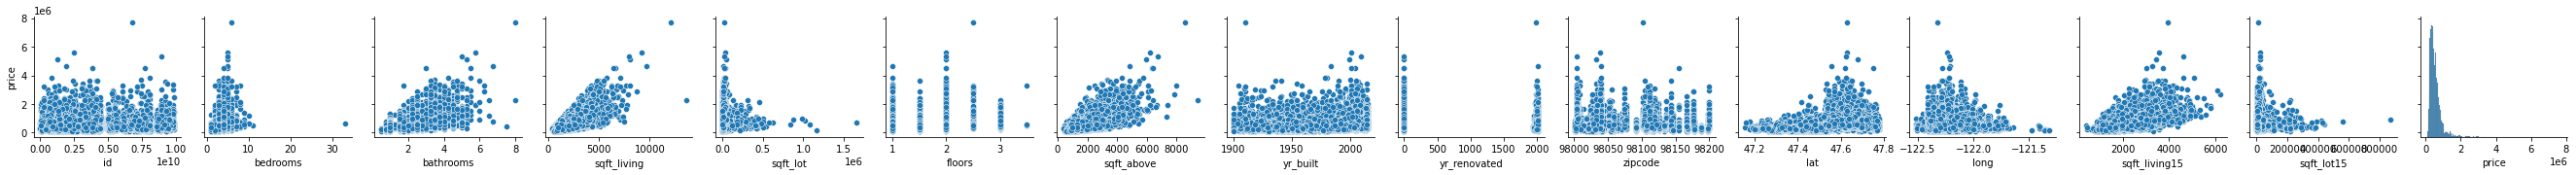

In [144]:
sns.pairplot(pd.concat([X_train, y_train], axis=1), y_vars=['price'])

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=827342324)
X_train.head(10)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
18149,5700000600,7/2/2014,5,2.50,2950,5500,1.5,NO,NONE,Very Good,7 Average,1720,1230.0,1918,0.0,98144,47.5785,-122.293,2200,5000
5875,8857310010,12/19/2014,2,1.50,1290,1749,1.0,NO,NONE,Average,8 Good,660,630.0,1969,NaN,98008,47.6118,-122.116,1860,1749
11799,2206500550,11/17/2014,3,1.00,1040,9800,1.0,NO,NONE,Good,7 Average,1040,0.0,1955,0.0,98006,47.5765,-122.155,1280,8880
18321,925049318,8/11/2014,3,1.75,1550,4054,1.5,NO,NONE,Good,7 Average,1550,0.0,1926,0.0,98115,47.6743,-122.301,1510,3889
4613,4022900569,10/17/2014,3,1.75,1900,10454,1.0,NaN,NONE,Average,7 Average,1390,510.0,1978,0.0,98155,47.7748,-122.291,2000,12000
10413,7129800036,1/14/2015,2,0.50,580,6900,1.0,NO,NONE,Average,5 Fair,580,0.0,1941,0.0,98118,47.5135,-122.262,1570,5040
12395,9206950200,3/10/2015,2,2.50,1320,1957,1.0,NaN,NONE,Average,8 Good,660,660.0,2004,NaN,98106,47.5364,-122.365,1420,2198
18653,5490700035,8/7/2014,4,1.50,1870,7220,2.0,NO,NONE,Average,7 Average,1870,0.0,1956,0.0,98155,47.7700,-122.319,1550,7592
4934,302000545,1/27/2015,4,2.25,2710,22860,1.0,NO,NONE,Good,7 Average,1850,860.0,1962,0.0,98001,47.3207,-122.266,1700,22860
9059,6052401215,6/9/2014,2,1.00,1200,9000,1.0,NO,AVERAGE,Very Good,6 Low Average,1200,0.0,1917,0.0,98198,47.4039,-122.323,1660,9000


In [93]:
drop_features = ['id', 'date','yr_renovated', 'zipcode']
numeric_features = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
categorical_features = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', ]

In [133]:
#Cleaning functions
def clean(df):
    df.loc[df['sqft_basement'] == '?', 'sqft_basement'] = np.nan
clean(X_train)
clean(X_test)

/Users/skylarenglish/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [260]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median", add_indicator=True)), ("scaler", MinMaxScaler())]
)


categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [270]:
models = {'Baseline':
              {'regressor': DummyRegressor(),
               'preprocessor': preprocessor,
               'output': None,
               'fit_regressor': None,
               'time_ran' : None
              },
          
          'Multiple':
              {'regressor': LinearRegression(),
               'preprocessor': preprocessor,
               'output': None,
               'fit_regressor': None,
               'time_ran': None
              },
          'Polynomial':
              {'regressor': LinearRegression(),
               'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median')),
                                                 ('polynomial', PolynomialFeatures(2)),
                                                 ('scaler', StandardScaler())]),
                                 ['sqft_living', 'sqft_lot', 'sqft_above',
                                  'sqft_basement', 'yr_built', 'lat', 'long',
                                  'sqft_living15', 'sqft_lot15']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['bedrooms', 'bathrooms', 'floors',
                                  'waterfront', 'view', 'condition',
                                  'grade'])]),
               'output': None,
               'fit_regressor': None,
               'time_ran': None
              },          
         }

In [271]:
for name, model in models.items():
    print(name)
    X_train_processed = model['preprocessor'].fit_transform(X_train)
    X_test_processed = model['preprocessor'].transform(X_test)
    model['fit_regressor'] = model['regressor'].fit(X_train_processed, y_train)
    model['output'] = model['fit_regressor'].score(X_test_processed, y_test)
    model['time_ran'] = time.asctime()
    
    print(model)

Baseline
{'regressor': DummyRegressor(), 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median')),
                                                 ('scaler', MinMaxScaler())]),
                                 ['sqft_living', 'sqft_lot', 'sqft_above',
                                  'sqft_basement', 'yr_built', 'lat', 'long',
                                  'sqft_living15', 'sqft_lot15']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['bedrooms', 'bathrooms', 'floors',
                                  'waterfront', 'view', 'condition',
                                  'grade'])]), 'output': -3.186327378834619e-05, 'fit_regressor': DummyRegressor(), 'time_ran': 'Fri Jan  7 11:18:54 2022'}
